# Wind energy production forecast from Met.no weather forecast

In [1]:
%matplotlib notebook
import urllib.request
import numpy as np
import simplejson as json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import datetime
import dateutil.parser
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import requests
from netCDF4 import Dataset
from dh_py_access.lib.dataset import dataset as dataset
import dh_py_access.package_api as package_api
import dh_py_access.lib.datahub as datahub
np.warnings.filterwarnings('ignore')

With this notebook we illustrate how one might improve weather forecast for wind energy production, considering that turbine height is different from 10m wind height, that is usual in weather data, and that wind energy production does not depend only on wind speed, but also air density.

We look at weather data that is available for the Baltic Sea region.

In [2]:
API_key = open("APIKEY").read().strip()
dh=datahub.datahub_main(API_key)

We use a simple dh_py_access library for controlling REST requests.

In [3]:
fmi_hirlam_surface = dataset('fmi_hirlam_surface',dh)
metno_harmonie_metcoop = dataset('metno_harmonie_metcoop',dh)
metno_harmonie_wind = dataset('metno_harmonie_wind_det',dh)
gfs = dataset('noaa_gfs_pgrb2_global_forecast_recompute_0.25degree',dh)

dh_py_access provides some easy to use functions to list dataset metadata

In [28]:
## Does not look good in github 
##gfs.variable_names()

Initialize coordinates and reftime. Please not that more recent reftime, than computed below, may be available for particular dataset. We just use conservative example for demo

In [18]:
lon = 22
lat = 59+6./60
today = datetime.datetime.today()
reft = datetime.datetime(today.year,today.month,today.day,int(today.hour/6)*6) - datetime.timedelta(hours=12)
reft = reft.isoformat()
##reft = "2018-02-11T18:00:00"
arg_dict = {'lon':lon,'lat':lat,'reftime_start':reft,'reftime_end':reft,'count':250}
arg_dict_metno_wind_det = dict(arg_dict, **{'vars':'wind_u_z,wind_v_z,air_density_z'})
arg_dict_metno_harm_metcoop = dict(arg_dict, **{'vars':'u_wind_10m,v_wind_10m'})
arg_dict_hirlam = dict(arg_dict, **{'vars':'u-component_of_wind_height_above_ground,v-component_of_wind_height_above_ground'})
arg_dict_gfs = dict(arg_dict, **{'vars':'ugrd_m,vgrd_m','count':450})

Fetch data and convert to Pandas dataframe

In [19]:
dmw = metno_harmonie_wind.get_json_data_in_pandas(**arg_dict_metno_wind_det)
dmm = metno_harmonie_metcoop.get_json_data_in_pandas(**arg_dict_metno_harm_metcoop)
dhs = fmi_hirlam_surface.get_json_data_in_pandas(**arg_dict_hirlam)
dgfs = gfs.get_json_data_in_pandas(**arg_dict_gfs)

In [29]:
## show how to filter Pandas
## dgfs[dgfs['z']==80]

Filter out necessary data from the DataFrames

<IPython.core.display.Javascript object>


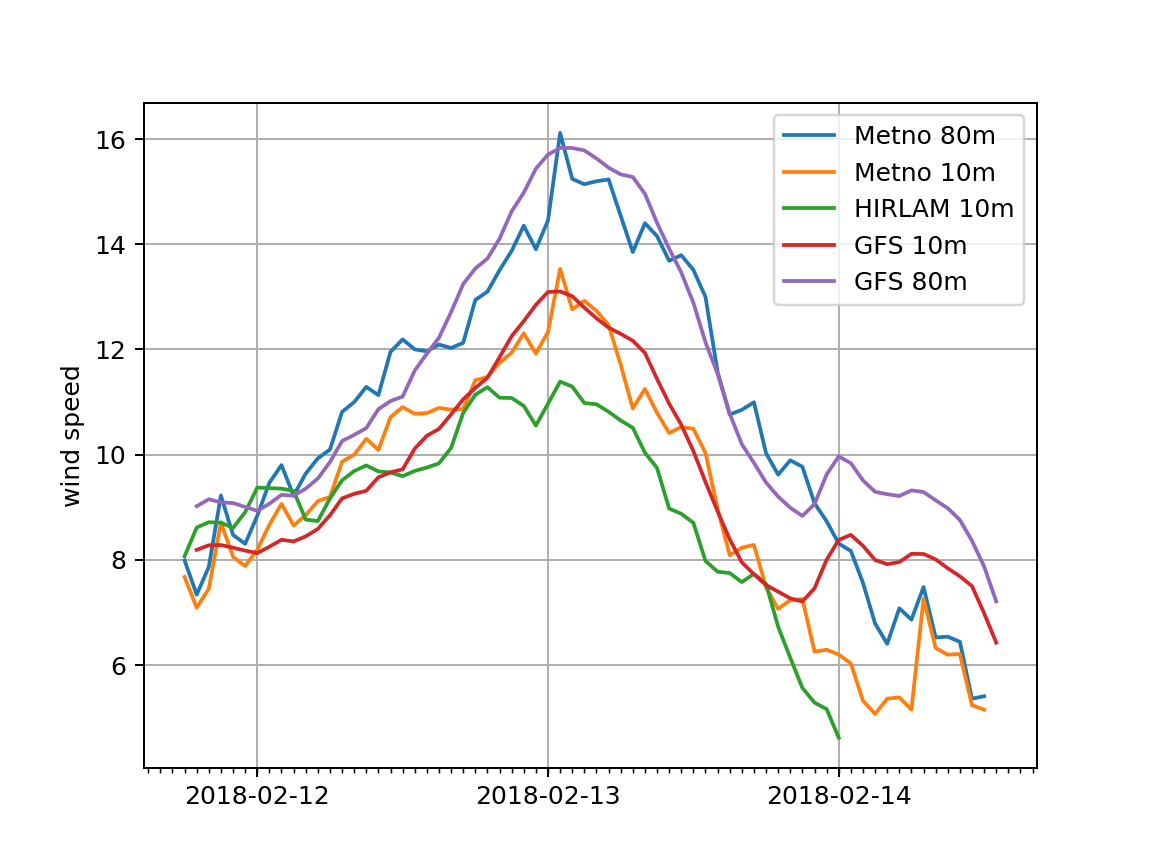

In [23]:
vel80_metno = np.array(np.sqrt(dmw[dmw['z']==80]['wind_u_z']**2 + dmw[dmw['z']==80]['wind_v_z']**2))
vel10_metno = np.array(np.sqrt(dmm['u_wind_10m']**2 + dmm['v_wind_10m']**2))
vel10_hirlam = np.array(np.sqrt(dhs['u-component_of_wind_height_above_ground']**2 + 
                          dhs['v-component_of_wind_height_above_ground']**2))
vel10_gfs = np.sqrt(dgfs[dgfs['z']==10]['ugrd_m']**2+dgfs[dgfs['z']==10]['vgrd_m']**2)
vel80_gfs = np.sqrt(dgfs[dgfs['z']==80]['ugrd_m']**2+dgfs[dgfs['z']==80]['vgrd_m']**2)
t_metno = [dateutil.parser.parse(i) for i in dmw[dmw['z']==80]['time']]
t_metno_10 = [dateutil.parser.parse(i) for i in dmm['time']]
t_hirlam = [dateutil.parser.parse(i) for i in dhs['time']]
t_gfs_10 = [dateutil.parser.parse(i) for i in dgfs[dgfs['z']==10]['time']]
t_gfs_80 = [dateutil.parser.parse(i) for i in dgfs[dgfs['z']==80]['time']]

fig, ax = plt.subplots()
days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%Y-%m-%d')
hours = mdates.HourLocator()
ax.set_ylabel("wind speed")
ax.plot(t_metno, vel80_metno, label='Metno 80m')
ax.plot(t_metno_10, vel10_metno, label='Metno 10m')
ax.plot(t_hirlam, vel10_hirlam, label='HIRLAM 10m')
gfs_lim=67
ax.plot(t_gfs_10[:gfs_lim], vel10_gfs[:gfs_lim], label='GFS 10m')
ax.plot(t_gfs_80[:gfs_lim], vel80_gfs[:gfs_lim], label='GFS 80m')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_minor_locator(hours)
#fig.autofmt_xdate()
plt.legend()
plt.grid()
plt.savefig("model_comp")

We easily see that differences between models can be larger than difference of 10m to 80m winds in the same model.

What role does density play in energy production?
From the theory we know that wind energy production is roughly 

$1/2 A \rho \mathbf{v}^3$, 

where $A$ is area, $\rho$ is air density and $\mathbf{v}$ is wind speed. We are not concerned about $A$, which is a turbine parameter, but we can analyse the linear relation of density and cube relation of wind speed itself.

First, let's see how the density varies over time

<IPython.core.display.Javascript object>


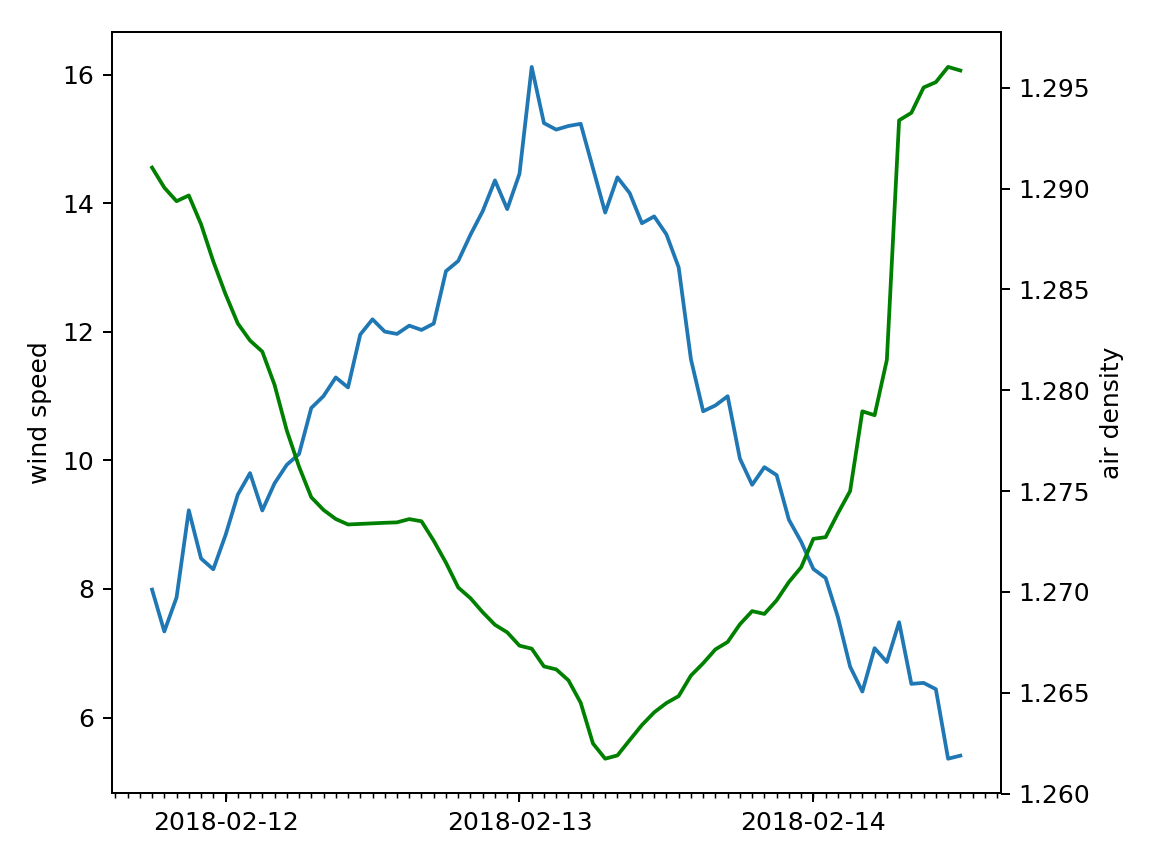

In [27]:
fig, ax = plt.subplots()
ax2 = ax.twinx()


days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%Y-%m-%d')
hours = mdates.HourLocator()
ax.plot(t_metno,vel80_metno)

aird80 = dmw[dmw['z']==80]['air_density_z']
ax2.plot(t_metno,aird80,c='g')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_minor_locator(hours)
ax.set_ylabel("wind speed")
ax2.set_ylabel("air density")
fig.tight_layout()
#fig.autofmt_xdate()
plt.savefig("density_80m")

No let's energy production looks compared to the wind speed

<IPython.core.display.Javascript object>


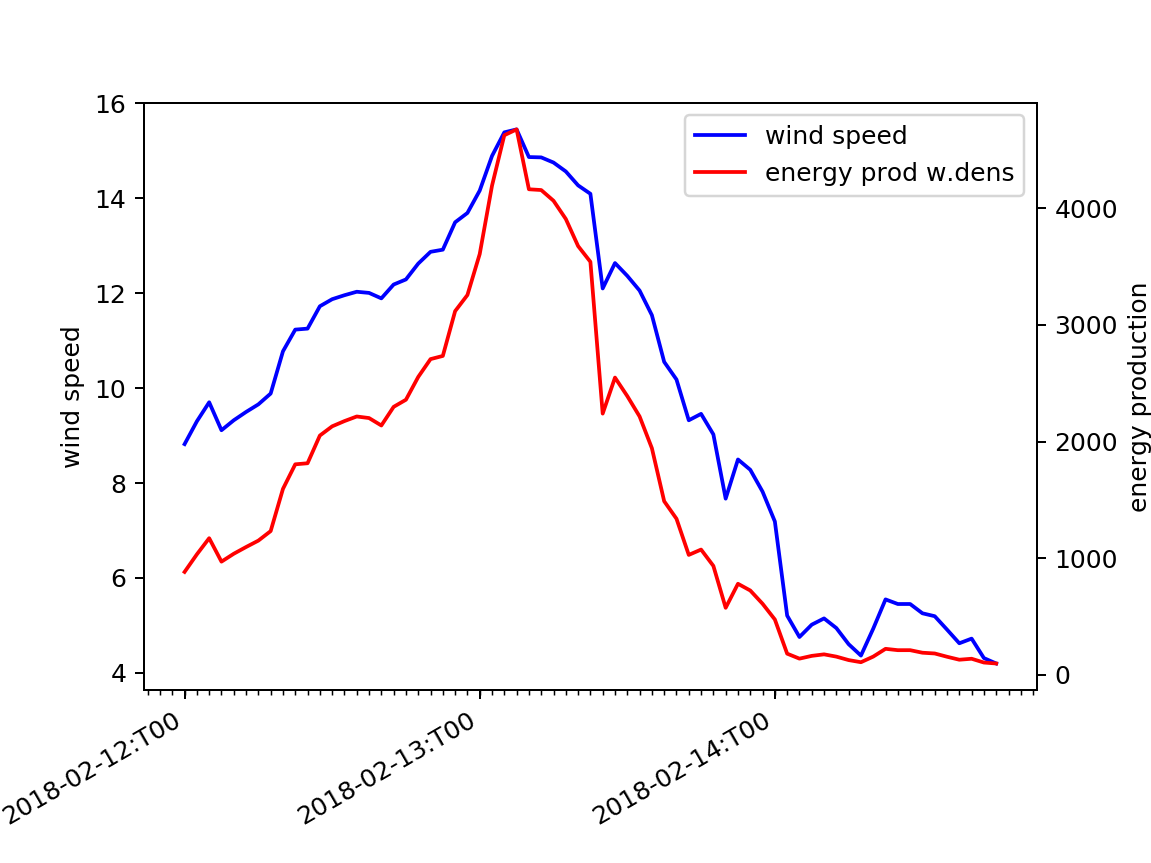

In [10]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_ylabel("energy production")
ax.set_ylabel("wind speed")
ax.plot(t_metno,vel80_metno, c='b', label='wind speed')
ax2.plot(t_metno,aird80*vel80_metno**3, c='r', label='energy prod w.dens')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_minor_locator(hours)
fig.autofmt_xdate()
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

Finally, let's analyse how much density changes vary over the whole domain during one forecast. For this purpose, we download the whole density field with package api

In [11]:
density = package_api.package_api(dh,'metno_harmonie_wind_det','air_density_z',-20,60,10,80,'full_domain_harmonie') 
density.make_package()
density.download_package()
density_data = Dataset(density.get_local_file_name())

Package exists


In [12]:
## biggest change of density in one location during forecast period
maxval = np.nanmax(density_data.variables['air_density_z'],axis=0)
minval = np.nanmin(density_data.variables['air_density_z'],axis=0)

Maximum relative change of air density in single location is:

In [13]:
print(np.nanmax(maxval-minval),np.nanmean(maxval-minval))

0.072317004 0.027498819
